# Lab 8: Graphical Models

The goal of this lab session is to code two methods to estimate the structure of undirected gaussian graphical models and compare them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Graphical Models

A graphical model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. The variables are represented by nodes and the relations between them are represented by edges.

### GLasso

Graphical Lasso is the name of the optimization problem that estimates the precision matrix of a multivariate gaussian and its name comes from the direct link with graphical models and the regularization term. 

Fill in the following class that implements the GLasso algorithm optimized by ADMM:

In [68]:
from sklearn.covariance import EmpiricalCovariance
np.random.seed(77)
class my_GLasso():
    
    def __init__(self, mu, lambd, eps=1e-4, max_iter = 60):
        '''
        Parameters:
        lambda : float
            Penalization parameter selected.
        mu: float>0
        eps : float
             Convergence parameter
        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.eps = eps
        self.mu = mu
        self.lambd = lambd
        self.max_iter = max_iter
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO:
        # initialize Y, Z
        n, p = X.shape
        rd = np.random.rand(p,p)
        Y = (rd + rd.T)/2
        Z = np.zeros((p,p))
        #mean = 1/n * np.sum(X, axis=0)
        S = np.zeros((p,p))
        #X_ = X - mean
        #for i in range(X_.shape[0]):
            #S += np.outer(X_[i].ravel(), X_[i].ravel())
        #self.covariance_ = np.linalg.inv(1/n * S)
        S = EmpiricalCovariance().fit(X).covariance_
        self.covariance_ = np.linalg.inv(S)
        self.precision_ = np.ones((p,p))
        old_precision = np.zeros((p,p))
        i = 0
        while(not (self.convergence(self.precision_, old_precision))) and  i < self.max_iter:
            old_precision = self.precision_
            T = Y - Z - (1/self.mu) * self.covariance_
            egv_T, egvec_T = np.linalg.eig(T)
            self.precision_ = 0.5 * egvec_T.T @ np.diag(egv_T + np.sqrt(np.square(egv_T) + 4/self.mu)) @ egvec_T
            Y = self.soft_threshold(self.precision_ + Z, self.lambd/self.mu)
            Z += self.mu * (self.precision_ - Y)
            i += 1
        return self
    
    def convergence(self, old, new):
        return np.linalg.norm(old - new) <= self.eps
    
    @staticmethod
    def soft_threshold(X, thresh):
        return np.sign(X) * np.maximum(np.abs(X) - thresh, 0)

Estimating the precision matrix from 60 samples... 



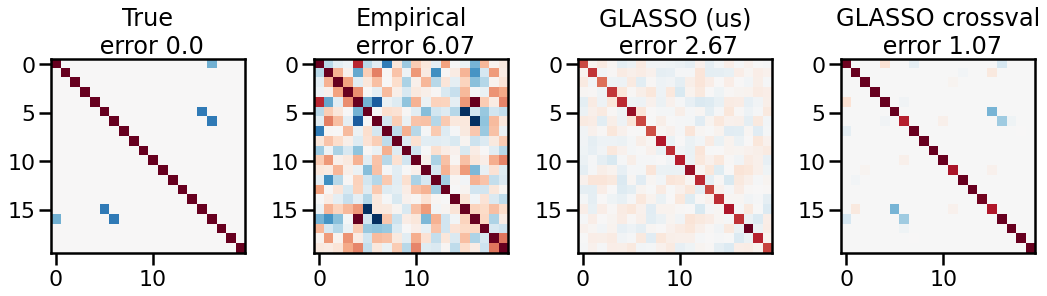

In [146]:
# Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

print(f'Estimating the precision matrix from {n_samples} samples... \n')


# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Graphical Lasso with cross validation 
from sklearn.covariance import GraphicalLassoCV
model = GraphicalLassoCV(cv=5)
model.fit(data)
prec_glassocv = model.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Graphical Lasso estimation using our implementation
model = my_GLasso(mu=1, lambd=0.1, max_iter=100)
model.fit(data)
prec_glasso = model.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)
vmax = prec_glasso.max()


# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()




First of all, even with playing around with mu & lambd, I can't have a better Precision Matrix with my implementation. I also try to use differents initialization. The thing is that it's much better than the Empirical Error, so I think it's working. However the model I implemented couldn't find the strong "correlation" in blue (in the real precision matrix).

We can see that the sklearn implementation performs well. 

According to the precision matrix (true & glasso), the majority of features in the graph aren't linked between them (in other words, there are few edges) which means that most of them are conditionally independent except for the (5 & 15 / 6 & 16 / 1 & 16)

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [212]:
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        covariance_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.coefs_ = list()
        
    def fit(self, X, cv=3, n_alphas=100):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """ 
        n, p = X.shape
        for i in range(p):
            X_train = X[:, np.arange(p) !=i]
            y = X[:,i]
            reg = LassoCV(cv=cv, n_alphas=n_alphas, random_state=0).fit(X_train,y)
            self.coefs_.append(reg.coef_)
        if self.rule is 'OR':
            self.graph_structure_ = self.build_or(p)
        elif self.rule is 'AND':
            self.graph_structure_ = self.build_and(p)
        return self
        
        
        
    def build_or(self, p):
        matrix = []
        for j in np.arange(0, p):
            sub = [0]*(j+1)
            for k in np.arange(j+1,p):
                if abs(self.coefs_[j-1][k-1]) != 0 or abs(self.coefs_[k-1][j-1]) !=0:
                    sub.append(1)
                else:
                    sub.append(0)
            matrix.append(np.array(sub))
        matrix = np.array(matrix)
        return matrix + matrix.T + np.diag([1]*p)
    
    def build_and(self, p):
        matrix = []
        for j in np.arange(0, p):
            sub = [0]*(j+1)
            for k in np.arange(j+1,p):
                if abs(self.coefs_[j-1][k-1]) != 0 and abs(self.coefs_[k-1][j-1]) !=0:
                    sub.append(1)
                else:
                    sub.append(0)
            matrix.append(np.array(sub))
        matrix = np.array(matrix)
        return matrix + matrix.T + np.diag([1]*p)

<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-212-aaef3f0dd566>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.rule is 'OR':
<ipython-input-212-aaef3f0dd566>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.rule is 'AND':


Generate an easy-to-check (non-trivial, p<=6) example and plot the 4 (real, GLasso, AND, OR) graphs. You can use `networkx` to plot the resulting graph.

In [132]:
n_samples = 30
n_features = 6

rng = np.random.RandomState(4)

# Truth
prec = make_sparse_spd_matrix(n_features, alpha=.96,
                              smallest_coef=0.2,
                              largest_coef=0.8,
                              random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)


# Graphical Lasso with cross validation 
model = GraphicalLassoCV(cv=5)
model.fit(data)
prec_glassocv = model.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Nodewise AND
model_AND = my_nodewise_regression(rule='AND')
model_AND.fit(data, cv=5)
prec_and = model_AND.graph_structure_
err_and = np.linalg.norm(prec - prec_and)

# Nodewise OR
model_OR = my_nodewise_regression(rule='OR')
model_OR.fit(data, cv=5)
prec_OR = model_OR.graph_structure_
err_OR = np.linalg.norm(prec - prec_OR)

# Visual comparison
titles = ["True", "Glasso", "NW Regression with AND", "NW Regression with OR"]
imgs = [prec, prec_glassocv, prec_and, prec_OR]
errors = [err, err_glasso, err_and, err_OR]

In [133]:
from networkx.convert_matrix import from_numpy_matrix
import networkx as nx

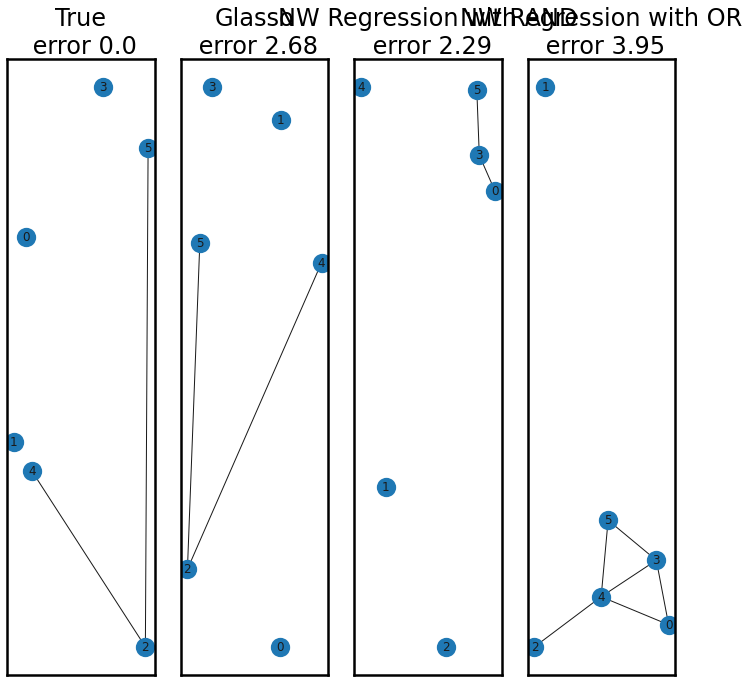

In [134]:
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    nx.draw_networkx(from_numpy_matrix(img),ax=ax)
    ax.set_title(title)
fig.tight_layout()

Only Glass could capture the correlation between the features.

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [225]:
np.exp(-4)

0.01831563888873418

In [158]:
block = np.fromfunction(lambda i,j : 0.9**abs(i-j), (30,30))
AR_block = np.kron(np.eye(10), block)
AR_block.shape

(300, 300)

In [160]:
exp_dec = np.fromfunction(lambda i,j : np.exp(-2*abs(i-j)), (300,300))
exp_dec.shape

(300, 300)

## Glasso

In [164]:
errors_glasso_AR = []
n_samples = [40, 80, 320]
n_features = 300
cov = np.linalg.inv(AR_block) 
mean = np.zeros(n_features)
for n in n_samples:
    data = np.random.multivariate_normal(mean, cov, n)
    model = GraphicalLassoCV(alphas = [0.01, 0.1, 1, 5, 10], cv=4, n_jobs=-1)
    model.fit(data)
    prec = model.precision_
    errors_glasso_AR.append(np.linalg.norm(prec - AR_block))

In [175]:
errors_glasso_EXP = []
cov = np.linalg.inv(exp_dec) 
mean = np.zeros(n_features)
for n in n_samples:
    data = np.random.multivariate_normal(mean, cov, n)
    model = GraphicalLassoCV(alphas = [0.01, 0.1, 1, 5, 10], cv=4, n_jobs=-1)
    model.fit(data)
    prec = model.precision_
    errors_glasso_EXP.append(np.linalg.norm(prec - exp_dec))

## NodeWise

In [187]:
import copy
threshold_AR = np.std(AR_block) - np.mean(AR_block)
threshold_exp = np.std(exp_dec) - np.mean(exp_dec)
AR_bin = copy.deepcopy(AR_block)
EXP_bin = copy.deepcopy(exp_dec)
AR_bin[AR_bin <= threshold_AR] = 0
AR_bin[AR_bin > threshold_AR] = 1
EXP_bin[EXP_bin <= threshold_exp] = 0
EXP_bin[EXP_bin > threshold_exp] = 1
EXP_bin = EXP_bin.astype(int)
AR_bin = AR_bin.astype(int)

In [213]:
from sklearn.metrics import accuracy_score, f1_score
acc_AR = []
f1_AR = []
n_samples = [40, 80, 320]
n_features = 300
cov = np.linalg.inv(AR_block) 
mean = np.zeros(n_features)
for n in n_samples:
    data = np.random.multivariate_normal(mean, cov, n)
    model = my_nodewise_regression(rule='AND')
    model.fit(data, cv=2, n_alphas=50)
    prec = model.graph_structure_
    acc_AR.append(accuracy_score(AR_bin.flatten(), prec.flatten()))
    f1_AR.append(f1_score(AR_bin.flatten(), prec.flatten()))

/Users/omarsouaidi/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06449351144637369, tolerance: 0.027079185578865118
  model = cd_fast.enet_coordinate_descent(
/Users/omarsouaidi/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06951906545563878, tolerance: 0.03686561805691632
  model = cd_fast.enet_coordinate_descent(
/Users/omarsouaidi/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07341956887656079, tolerance: 0.05397362957235155
  model = cd_fast.enet_coordinate_descent(
/Users/omarsouaidi/opt/miniconda3/lib/p

In [214]:
acc_exp = []
f1_exp = []
n_samples = [40, 80, 320]
n_features = 300
cov = np.linalg.inv(exp_dec) 
mean = np.zeros(n_features)
for n in n_samples:
    data = np.random.multivariate_normal(mean, cov, n)
    model = my_nodewise_regression(rule='AND')
    model.fit(data, cv=2, n_alphas=50)
    prec = model.graph_structure_
    acc_exp.append(accuracy_score(EXP_bin.flatten(), prec.flatten()))
    f1_exp.append(f1_score(EXP_bin.flatten(), prec.flatten()))

/Users/omarsouaidi/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022085948711825454, tolerance: 0.02051893316995947
  model = cd_fast.enet_coordinate_descent(
/Users/omarsouaidi/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012955815709301766, tolerance: 0.012693898267213146
  model = cd_fast.enet_coordinate_descent(
/Users/omarsouaidi/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019951616895836133, tolerance: 0.017731944730088066
  model = cd_fast.enet_coordinate_descent(
/Users/omarsouaidi/opt/miniconda3/l

In [218]:
import pandas as pd
sumup_glasso = pd.DataFrame({'AR': errors_glasso_AR, 'EXP': errors_glasso_EXP}, index=n_samples)
sumup_nodewise = pd.DataFrame({'AR_acc': acc_AR, 'EXP_acc': acc_exp, 'AR_f1': f1_AR, 'EXP_f1': f1_exp}, index=n_samples)

In [219]:
# GLASSO
sumup_glasso.head()

,AR,EXP
40,48.349859,5.792348
80,48.393691,4.510947
320,47.490535,3.604369


In [220]:
# NodeWise
sumup_nodewise.head()

,AR_acc,EXP_acc,AR_f1,EXP_f1
40,0.912711,0.993289,0.074894,0.498339
80,0.914467,0.993289,0.111291,0.498339
320,0.915644,0.993378,0.326234,0.503333


Well except for the f1 score of AR, the number of samples that we have doesn't affect strongly the performance which shows that these estimations can (it always depend on the noise, type of data) work even if we have few data (contrary to other models)

In [222]:
np.mean(AR_block) / np.mean(exp_dec)

10.103719188400952

In [227]:
np.log(0.01)/np.log(0.9)

43.70869065356567

The error in AR is bigger than the one of the exponential because it's not the same scale (mean(AR)/mean(exp) = 10) and if you multiply error_exp by 10, you find exp_AR, which shows that the glasso model fit well both distribution.

The error seems big but remember now that we have 300*300 = 9000 components

I think that the f1_score of exponential model is greater than the one of the AR because of the distribution of the precision matrix. 95% of the variance is on the diagonal element of the exponential matrix (if we move away by at least two indices, the values are smaller than exp(-4) = 0.01 ) in comparison with the AR block matrix (if we want the value to be smaller than 0.01, we need to get np.log(0.01) / np.log(0.9) = 44 indices) .
As a consequence, in the nodewise regression, the lasso regression (feature by feature) have more latent variables to catch in the AR block model than the exponential model.